In [50]:
import timeit
from pathlib import Path
import re
import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


TREES_PATH = Path.cwd() / "BALiBase_trees"


In [ ]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

# for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
#     scale_tree(str(tree_path), 10, True)


In [75]:
def refresh_sim(tree_file):
    ROOT_SEQUENCE_LENGTH = 1000

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=0.09, rate_del=0.03,
                                deletion_extra_edge_length=50,
                                switch_factor=500,
                                seed=243)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim
time_labels = ["tree", "hybrid", "blocktree", "blocklist", "naive"]


In [77]:

time_winners = []
measured_times: list[list[float]] = []





for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path)
    hybrid_time = timeit.timeit(sim.msa_from_hybrid, number=5)
    blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=5)
    blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=5)
    naive_time = 1000#timeit.timeit(sim.msa_from_naive, number=5)

    time_measures = [tree_path, hybrid_time, blocktree_time, blocklist_time, naive_time]
    print(time_measures)
    measured_times.append(time_measures)



[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20031_60.tree'), 1.1166544850020728, 1.3742040559991437, 1.4234514250019856, 1000]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20023_31.tree'), 0.4484635459994024, 0.6374911239981884, 0.4300018209978589, 1000]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20014_65.tree'), 2.4773909529976663, 2.791958728001191, 4.587605369000812, 1000]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS12029_12.tree'), 0.10776167099902523, 0.1841379979996418, 0.1075802699997439, 1000]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS50016_18.tree'), 0.6628305750018626, 0.8828324830028578, 0.7222249709993775, 1000]
[PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS11007_9.tree'), 0.16624848100036616, 0.2731905690015992, 0.17223322999780066, 1000]
[PosixPath('/home/elyalab/De

KeyboardInterrupt: 

In [15]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocklist()


5.94 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocktree()

6.23 s ± 67.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_hybrid()

5.84 s ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
times_df = pd.DataFrame(measured_times, columns=time_labels).reset_index()

# times_df.idxmin(axis=1).value_counts()
times_df.loc[(times_df.blocklist - times_df.hybrid).abs().idxmax()].to_list()

[np.int64(13),
 PosixPath('/home/elyalab/Dev/failed_syncs/evo-sim/benchmark/BALiBase_trees/BBS20032_61.tree'),
 np.float64(2.052339005000249),
 np.float64(2.265365870000096),
 np.float64(4.914450854001188),
 np.int64(1000)]

In [27]:
times_df.to_csv("all_methods_comparison.csv")

In [58]:
times_df = pd.read_csv("all_methods_comparison.csv", index_col=0)
times_df

,index,tree,hybrid,blocktree,blocklist,naive
0,0,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.165999,0.179568,0.165506,0.921123
1,1,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.167249,0.177158,0.166856,0.896822
2,2,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.173866,0.177236,0.168393,0.939330
3,3,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.161233,0.172194,0.163353,0.944189
4,4,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.164119,0.175849,0.165812,0.969009
...,...,...,...,...,...,...
536,536,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.176466,0.183620,0.168265,0.946763
537,537,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.167242,0.188015,0.169083,0.980289
538,538,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.165369,0.173465,0.165600,0.872306
539,539,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.164416,0.180484,0.166387,0.947357


In [80]:
times_df["naive"] = 1000

In [81]:
times_df.iloc[:,2:].idxmin(axis=1).value_counts()


hybrid       25
blocklist     9
Name: count, dtype: int64

In [70]:
times_df

,index,tree,hybrid,blocktree,blocklist,naive
0,0,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,1.123781,1.389651,1.405784,1000
1,1,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.491710,0.629502,0.435226,1000
2,2,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,2.544308,2.789955,4.691737,1000
3,3,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.108364,0.187547,0.108661,1000
4,4,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.811714,0.900217,0.734727,1000
5,5,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.239640,0.278096,0.177033,1000
6,6,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.055099,0.093787,0.053573,1000
7,7,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.164307,0.250269,0.153578,1000
8,8,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.057731,0.081812,0.047042,1000
9,9,/home/elyalab/Dev/failed_syncs/evo-sim/benchma...,0.636112,0.768114,0.698766,1000


In [82]:
times_df.describe()

,index,hybrid,blocktree,blocklist,naive
count,34.000000,34.000000,34.000000,34.000000,34.0
mean,16.500000,0.531670,0.683024,0.713738,1000.0
std,9.958246,0.544827,0.604354,1.097502,0.0
min,0.000000,0.046854,0.081039,0.046367,1000.0
25%,8.250000,0.156958,0.258951,0.162350,1000.0
50%,16.500000,0.383881,0.562941,0.373933,1000.0
75%,24.750000,0.617440,0.850918,0.706401,1000.0
max,33.000000,2.477391,2.791959,4.914451,1000.0


In [83]:
# stats.f_oneway(times_df["naive"], times_df["blocktree"], times_df["blocklist"], times_df["hybrid"])
# stats.f_oneway(times_df["blocktree"], times_df["blocklist"], times_df["hybrid"])

tuk = stats.tukey_hsd(times_df["naive"], times_df["blocklist"], times_df["blocktree"], times_df["hybrid"])

In [84]:
print(tuk)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    999.286     0.000   998.855   999.717
 (0 - 2)    999.317     0.000   998.886   999.748
 (0 - 3)    999.468     0.000   999.037   999.899
 (1 - 0)   -999.286     0.000  -999.717  -998.855
 (1 - 2)      0.031     0.998    -0.400     0.462
 (1 - 3)      0.182     0.691    -0.249     0.613
 (2 - 0)   -999.317     0.000  -999.748  -998.886
 (2 - 1)     -0.031     0.998    -0.462     0.400
 (2 - 3)      0.151     0.798    -0.280     0.582
 (3 - 0)   -999.468     0.000  -999.899  -999.037
 (3 - 1)     -0.182     0.691    -0.613     0.249
 (3 - 2)     -0.151     0.798    -0.582     0.280



[Text(0, 0, 'Hybrid'),
 Text(1, 0, 'Blocktree'),
 Text(2, 0, 'Blocklist'),
 Text(3, 0, 'Naive')]

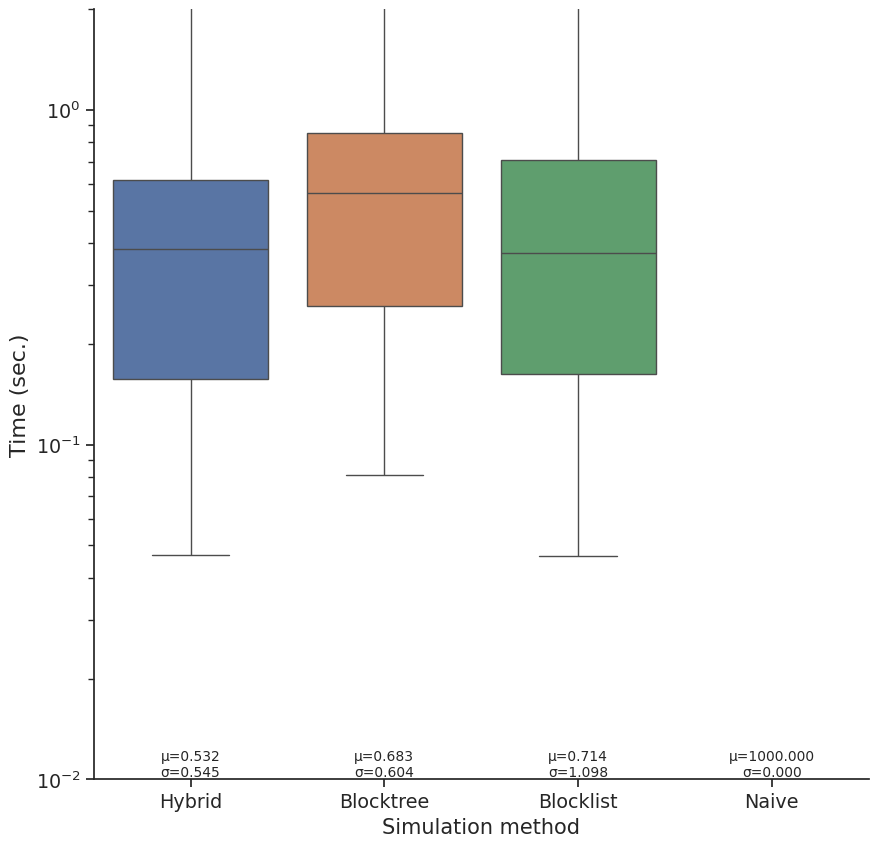

In [85]:

# ax = times_df.plot.scatter(x="index", y=time_labels[1], label=time_labels[1], figsize=(20, 10), s=40)
sns.set_theme(style="ticks", font_scale=1.25)
ax = sns.boxplot(data=times_df.iloc[:,2:], whis=(0, 100))
ax.set_yscale("log")
ax.set_ylim(0.01, 2)
ax.set_ylabel("Time (sec.)", size=16)
ax.set_xlabel("Simulation method")
for idx,label in enumerate(time_labels[1:]):
    mean = times_df[label].mean()
    std = times_df[label].std()
    plt.text(idx, plt.ylim()[0], 
             f'μ={mean:.3f}\nσ={std:.3f}',
             horizontalalignment='center',
             verticalalignment='bottom', size=10)
ax.figure.set_size_inches(10, 10)
sns.despine();

ticks = ax.get_xticks()
ax.set_xticks(ticks)
new_xticklabels = [item.get_text().title() for item in ax.get_xticklabels()]
ax.set_xticklabels(new_xticklabels)

# plt.savefig("assets/orthomam_benchmark.svg",bbox_inches="tight")
# plt.savefig("assets/orthomam_benchmark.png",bbox_inches="tight", dpi=300)

# times_df.plot.box(x="index", y=time_labels[2], ax=ax, label=time_labe
# ls[2], s=40)
# times_df.plot.box(x="index", y=time_labels[3], ax=ax, label=time_labels[3], s=40)
# times_df.plot.box(x="index", y=time_labels[4], ax=ax, label=time_labels[4], s=40)
# ax.set_yscale("log")
# ax.set_ylabel("Time (sec.)", fontsize=25)
# ax.set_xlabel("")

# ax.legend(fontsize=25)
